# Hamiltonian Simulation by Generalized Quantum Signal Processing

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `HamiltonianSimulationByGQSP`
Hamiltonian simulation using Generalized QSP given a qubitized quantum walk operator.

Given the Szegedy Quantum Walk Operator for a Hamiltonian $H$ constructed from SELECT and PREPARE oracles,
one can construct a block-encoding of $e^{-iHt}$ using GQSP (Corollary 8).

### Recap: Qubitization Walk Operator

For a Hamiltonian $H = \sum_j \alpha_j U_j$ where $U_j$ are unitaries and $\alpha_j \ge 0$,
we are given the SELECT and PREPARE oracles:
$$ \text{SELECT} = \sum_j |j\rangle\langle j| \otimes U_j $$
$$ \text{PREPARE} |0\rangle = \sum_j \frac{\sqrt{\alpha_j}}{\|\alpha\|_1} |j\rangle $$

We can then implement the [QubitizationWalkOperator](../qubitization_walk_operator.ipynb) that encodes the spectrum of $H$ in the eigenphases of the walk operator $W$.

### Approximating the function $e^{i\theta} \mapsto e^{it\cos\theta}$

We can use the [Jacobi-Anger expansion](https://en.wikipedia.org/wiki/Jacobi%E2%80%93Anger_expansion) to obtain low-degree polynomial approximations for the $\cos$ function:

$$
    e^{it\cos\theta} = \sum_{n = -\infty}^{\infty} i^n J_n(t) (e^{i\theta})^n
$$
where $J_n$ is the $n$-th [Bessel function of the first kind](https://en.wikipedia.org/wiki/Bessel_function#Bessel_functions_of_the_first_kind).

If we cut-off the above to terms upto degree $d$, we get

$$
    P[t](z) = \sum_{n = -d}^d i^n J_n(t) z^n
$$

Polynomial approximations of the above are provided in the [`qualtran.linalg.jacobi_anger_approximations`](../../linalg/jacobi_anger_approximations.py) module.

### Simulation: Block-encoding $e^{-iHt}$

As the eigenphases of the walk operator above are $e^{-i\arccos(E_k / \|\alpha\|_1)}$,
we can use the GQSP polynomial with $P = P[-\|\alpha\|_1 t]$ to obtain $P(U) = e^{-iHt}$.
The obtained GQSP operator $G$ can then be used with two calls to the PREPARE oracle to simulate the hamiltonian:

$$
    (I \otimes \text{PREPARE}^\dagger \otimes I) G (I \otimes \text{PREPARE} \otimes I) |0\rangle|0\rangle|\psi\rangle = |0\rangle|0\rangle e^{-iHt}|\psi\rangle
$$

This therefore block-encodes $e^{-iHt}$ in the block where the signal qubit and selection registers are all $|0\rangle$.

#### References
 - [Generalized Quantum Signal Processing](https://arxiv.org/abs/2308.01501). Motlagh and Wiebe. (2023). Theorem 7, Corollary 8. 

#### Parameters
 - `walk_operator`: qubitization walk operator of $H$ constructed from SELECT and PREPARE oracles.
 - `t`: time to simulate the Hamiltonian, i.e. $e^{-iHt}$
 - `precision`: the precision $\epsilon$ of the final block encoded $e^{-iHt}$. Split into two: half to approximate $e^{it\cos\theta}$ to a polynomial, and half to synthesize the underlying GQSP rotations.


In [2]:
from qualtran.bloqs.hamiltonian_simulation.hamiltonian_simulation_by_gqsp import HamiltonianSimulationByGQSP

### Example Instances

In [3]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import (
    get_walk_operator_for_hubbard_model,
)

walk_op = get_walk_operator_for_hubbard_model(2, 2, 1, 1)
hubbard_time_evolution_by_gqsp = HamiltonianSimulationByGQSP(walk_op, t=5, precision=1e-7)

In [4]:
import sympy

from qualtran.bloqs.chemistry.hubbard_model.qubitization import (
    get_walk_operator_for_hubbard_model,
)

tau, t, inv_eps = sympy.symbols(r"\tau t \epsilon^{-1}", positive=True)
walk_op = get_walk_operator_for_hubbard_model(2, 2, tau, 4 * tau)
symbolic_hamsim_by_gqsp = HamiltonianSimulationByGQSP(walk_op, t=t, precision=1 / inv_eps)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([hubbard_time_evolution_by_gqsp, symbolic_hamsim_by_gqsp],
           ['`hubbard_time_evolution_by_gqsp`', '`symbolic_hamsim_by_gqsp`'])

### Call Graph

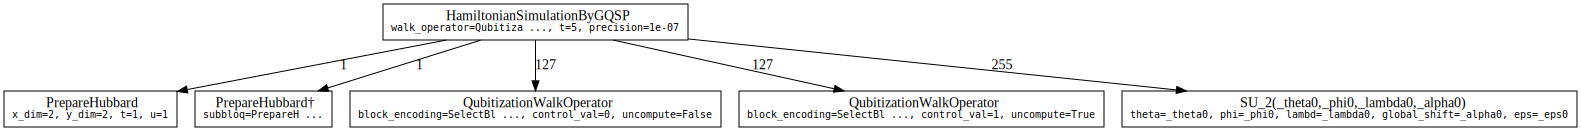

#### Counts totals:
 - `Adjoint(subbloq=PrepareHubbard)`: 1
 - `PrepareHubbard`: 1
 - `QubitizationWalkOperator`: 127
 - `QubitizationWalkOperator`: 127
 - `SU_2(_theta0,_phi0,_lambda0,_alpha0)`: 255

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
hubbard_time_evolution_by_gqsp_g, hubbard_time_evolution_by_gqsp_sigma = hubbard_time_evolution_by_gqsp.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hubbard_time_evolution_by_gqsp_g)
show_counts_sigma(hubbard_time_evolution_by_gqsp_sigma)

In [7]:
from qualtran.resource_counting.generalizers import generalize_rotation_angle, ignore_split_join, ignore_alloc_free
_, symbolic_hamsim_by_gqsp_sigma = symbolic_hamsim_by_gqsp.call_graph(max_depth=2, generalizer=[ignore_split_join, ignore_alloc_free, generalize_rotation_angle])
show_counts_sigma(symbolic_hamsim_by_gqsp_sigma)

#### Counts totals:
 - `Adjoint(subbloq=B[H])`: $\displaystyle C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right)$
 - `Adjoint(subbloq=ModAddK)`: 1
 - `Adjoint(subbloq=MultiAnd(n=3))`: 2
 - `Adjoint(subbloq=PrepareUniformSuperposition)`: 2
 - `B[H]`: $\displaystyle C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right)$
 - `CHadamard`: 2
 - `CNOT`: 10
 - `CSwap`: 2
 - `CSwap`: 4
 - `C[Ry(-2.214297435588181)]`: 1
 - `C[Ry(2.214297435588181)]`: 1
 - `GPhase(exp(1.0*I*pi*(_alpha0/pi + _lambda0/(2*pi) + _phi0/(2*pi) + 0.5)))`: $\displaystyle 2 C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right) + 1$
 - `H`: 4
 - `ModAddK`: 1
 - `MultiAnd(n=3)`: 2
 - `PrepareUniformSuperposition`: 2
 - `ReflectionUsingPrepare`: $\displaystyle C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right)$
 - `ReflectionUsingPrepare`: $\displaystyle C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right)$
 - `Rx(\phi)`: $\displaystyle 2 C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right) + 1$
 - `Ry(\phi)`: 2
 - `Rz(\phi)`: $\displaystyle 4 C_{JA} \left(t \left(16 \tau + \left\lfloor{16 \tau}\right\rfloor\right) + \frac{\log{\left(2 \epsilon^{-1} \right)}}{\log{\left(\log{\left(2 \epsilon^{-1} \right)} \right)}}\right) + 2$
 - `XGate`: 6